# Downloading and analyzing data from APIs

API stands for **Application Programming Interface**. We look at interfaces to **receive data from online sources**.

We will be using Python packages for this, and will not look much at what is going on underneath. 

**Two examples:**

1. For **Statistics Denmark**, Alessandro Martinello has written the `dstapi` package.
1. For **Federal Reserve Economic Data (FRED)**, we use the official `fredapi` package.

**Notes:**

1. Requires an internet connection.
1. Can be slow, or time out, if used by many simultanously (e.g. in a lecture).

**Table of contents**<a id='toc0_'></a>    
- 1. [Task from Descriptive Economics](#toc1_)    
- 2. [DST - Statistics Denmark](#toc2_)    
  - 2.1. [Step 1: Find data (table and variables)](#toc2_1_)    
  - 2.2. [Step 2: Download and clean the data](#toc2_2_)    
    - 2.2.1. [Alternative](#toc2_2_1_)    
  - 2.3. [Step 3: Verify data](#toc2_3_)    
  - 2.4. [Step 4: Analyze data](#toc2_4_)    
- 3. [US data from FRED](#toc3_)    
- 4. [Summary](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Install:** Install the required packages by uncommenting the commands below.

In [1]:
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi

In [2]:
import numpy as np
import pandas as pd

# APIs
from fredapi import Fred
from dstapi import DstApi

# plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Task from Descriptive Economics](#toc0_)

We can decompose GDP as

$$
\begin{aligned}
\text{GDP} &= \frac{\text{GDP}}{\text{Total hours}}
\times\frac{\text{Total hours}}{\text{Employed}}
\times\frac{\text{Employed}}{\text{Population}}
\times\text{Population} \\
&= \text{Productivity}
\times\text{Hours per employed}
\times\text{Employment ratio}
\times\text{Population}
\end{aligned}
$$ 

We can then **decompose GDP growth** as

$$
\begin{aligned}
\Delta\log(\text{GDP}) &= 
\Delta\log(\text{Productivity})
+\Delta\log(\text{Hours per employed})
+\Delta\log(\text{Employment ratio})
+\Delta\log(\text{Population})
\end{aligned}
$$ 

**Specifically**:

1. Calculate the growth decomposition  decade for decade for Denmark
1. Plot results in a stacked bar chart
1. Repeat the same for the US

## 2. <a id='toc2_'></a>[DST - Statistics Denmark](#toc0_)

**Technical details** on the API can be found [here](https://www.dst.dk/en/Statistik/hjaelp-til-statistikbanken/api).

**Code and detailed guide** for `dstapi` can be found [here](https://github.com/alemartinello/dstapi).

**Note:** The API has an English option, but not everything is translated...

### 2.1. <a id='toc2_1_'></a>[Step 1: Find data (table and variables)](#toc0_)

**Step 1:** Go to [Statistikbanken.dk](https://statistikbanken.dk/) and find a tablename such as `NAN1`.

In [3]:
NAN1 = DstApi('NAN1') 

Get quick overview of the available data in the table:

In [4]:
NAN1.tablesummary(language='en')

Table NAN1: Demand and supply by transaction, price unit and time
Last update: 2025-06-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LAN_C,"Pr. capita, 2020-prices, chained values, (1000...",False
2,Tid,59,1966,1966,2024,2024,True


We can go into more details:

In [5]:
NAN1.variable_levels('PRISENHED',language='en')

,id,text
0,V_M,"Current prices, (bill. DKK.)"
1,LAN_M,"2020-prices, chained values, (bill. DKK.)"
2,L_V,Period-to-period real growth (per cent)
3,V_C,"Pr. capita. Current prices, (1000 DKK.)"
4,L_VB,"Contribution to GDP growth, (percentage point)"
5,LAN_C,"Pr. capita, 2020-prices, chained values, (1000..."


In [6]:
TRANSAKT = NAN1.variable_levels('TRANSAKT',language='en')
I = TRANSAKT['id'].isin(['B1GQK','EMPH_DC','EMPM_DC'])
TRANSAKT[I]

,id,text
0,B1GQK,B.1*g Gross domestic product
29,EMPH_DC,Total actual hours worked (million hours)
30,EMPM_DC,"Total employment (1,000 persons)"


### 2.2. <a id='toc2_2_'></a>[Step 2: Download and clean the data](#toc0_)

A basic example:

In [7]:
# a. set download parameters
params = {
    'table': 'NAN1',
    'format': 'BULK', # semicolon separated file
    'lang': 'en',
    'variables': [
        {'code': 'TRANSAKT', 'values': ['B1GQK']},
        {'code': 'PRISENHED', 'values': ['LAN_M']},
        {'code': 'Tid', 'values': ['*']}, # '*' is everything
        ]
    }

# b. download
RealGDP = NAN1.get_data(params=params)

# c. display
display(RealGDP.head(5))
display(RealGDP.info())

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1970,926.6
1,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1986,1397.7
2,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1966,760.0
3,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1977,1096.8
4,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1978,1123.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TRANSAKT   59 non-null     object
 1   PRISENHED  59 non-null     object
 2   TID        59 non-null     int64 
 3   INDHOLD    59 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.0+ KB


None

Define function to download data:

In [8]:
def load_NAN1(TRANSAKT,PRISENHED,varname):

    params = {
        'table': 'NAN1',
        'format': 'BULK', # semicolon separated file
        'lang': 'en',
        'variables': [
            {'code': 'TRANSAKT', 'values': [TRANSAKT]},
            {'code': 'PRISENHED', 'values': [PRISENHED]},
            {'code': 'Tid', 'values': ['*']},
            ]
    }    

    # b. download
    df = DstApi('NAN1').get_data(params=params)

    # c. set types and rename
    df['TID'] = df['TID'].astype(int)
    df['INDHOLD'] = df['INDHOLD'].astype(float)
    df = df.drop(columns=['TRANSAKT','PRISENHED'])
    df = df.rename(columns={'INDHOLD': varname, 'TID': 'year'})
    df = df.set_index('year').sort_index()
    
    return df

Run it and join on year index:

In [9]:
df = load_NAN1('B1GQK','LAN_M','RealGDP')
df['RealGDP_per_capita'] = load_NAN1('B1GQK','LAN_C','RealGDP_per_capita')
df['TotalHours'] = load_NAN1('EMPH_DC','V_M','TotalHours')
df['Emp'] = load_NAN1('EMPM_DC','V_M','Emp')
df.head(5)

,RealGDP,RealGDP_per_capita,TotalHours,Emp
year,,,,
1966,760.0,159.0,4604.4,2322.8
1967,804.7,166.9,4537.2,2322.4
1968,851.8,175.4,4467.4,2339.9
1969,909.7,186.5,4453.3,2381.9
1970,926.6,187.7,4449.2,2411.1


#### 2.2.1. <a id='toc2_2_1_'></a>[Alternative](#toc0_)

Get all the data in one call:

In [10]:
# a. set download parameters
params = {
'table': 'NAN1',
'format': 'BULK',
'lang': 'en',
'variables': [
    {'code': 'TRANSAKT', 'values': ['B1GQK','EMPH_DC','EMPM_DC']},
    {'code': 'PRISENHED', 'values': ['LAN_M','LAN_C','V_M']},
    {'code': 'TID', 'values': ['*']},
    ]
} 

# b. download all data
df_dst = DstApi('NAN1').get_data(params=params)

# c. replace '..' with NaN and convert INDHOLD to float
I = df_dst['INDHOLD'] == '..'
df_dst.loc[I,'INDHOLD'] = 'nan'
df_dst['INDHOLD'] = df_dst.INDHOLD.astype(float)

df_dst.head(5)

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,"Pr. capita, 2020-prices, chained values, (1000...",1970,187.7
1,B.1*g Gross domestic product,"2020-prices, chained values, (bill. DKK.)",1970,926.6
2,B.1*g Gross domestic product,"Current prices, (bill. DKK.)",1970,128.1
3,Total actual hours worked (million hours),"Pr. capita, 2020-prices, chained values, (1000...",1970,NaN
4,Total actual hours worked (million hours),"2020-prices, chained values, (bill. DKK.)",1970,NaN


Pivot the table and rename columns:

In [11]:
df_ = df_dst.pivot_table(index='TID',columns=['TRANSAKT','PRISENHED'],values='INDHOLD')

df_ = df_.rename(columns={
    'B.1*g Gross domestic product': 'GDP',
    'Total actual hours worked (million hours)': 'TotalHours',
    'Total employment (1,000 persons)':'Employed',
    '2020-prices, chained values, (bill. DKK.)':'Real',
    'Pr. capita, 2020-prices, chained values, (1000 DKK.)':'Real_per_capita',
    'Current prices, (bill. DKK.)':'Nom',
    'TID':'year',
    })

df_.head(5)

TRANSAKT     GDP                        TotalHours Employed
PRISENHED   Real    Nom Real_per_capita        Nom      Nom
TID                                                        
1966       760.0   82.4           159.0     4604.4   2322.8
1967       804.7   90.8           166.9     4537.2   2322.4
1968       851.8  101.3           175.4     4467.4   2339.9
1969       909.7  115.6           186.5     4453.3   2381.9
1970       926.6  128.1           187.7     4449.2   2411.1

The columns are now tuples:

In [12]:
for col in df_.columns: print(col)

('GDP', 'Real')
('GDP', 'Nom')
('GDP', 'Real_per_capita')
('TotalHours', 'Nom')
('Employed', 'Nom')


Create equivalent data set:

In [13]:
df_alt = pd.DataFrame({
    'year': df_.index,
    'RealGDP': df_[('GDP','Real')],
    'RealGDP_per_capita': df_[('GDP','Real_per_capita')],
    'TotalHours': df_[('TotalHours','Nom')],
    'Emp': df_[('Employed','Nom')],
}).set_index('year').sort_index()

df_alt.head(5)

,RealGDP,RealGDP_per_capita,TotalHours,Emp
year,,,,
1966,760.0,159.0,4604.4,2322.8
1967,804.7,166.9,4537.2,2322.4
1968,851.8,175.4,4467.4,2339.9
1969,909.7,186.5,4453.3,2381.9
1970,926.6,187.7,4449.2,2411.1


### 2.3. <a id='toc2_3_'></a>[Step 3: Verify data](#toc0_)

Run basic describe:

In [14]:
df.describe().style.format('{:.1f}')

,RealGDP,RealGDP_per_capita,TotalHours,Emp
count,59.0,59.0,59.0,59.0
mean,1638.4,303.9,4046.2,2683.1
std,515.7,79.9,222.4,217.3
min,760.0,159.0,3651.4,2322.4
25%,1164.4,227.4,3923.4,2495.0
50%,1617.4,309.2,4001.2,2653.7
75%,2067.2,371.0,4157.8,2788.2
max,2591.0,433.5,4604.4,3217.4


Choose units:

In [15]:
units = {
    'RealGDP': 'billion DKK',
    'RealGDP_per_capita': 'thousand DKK',
    'TotalHours': 'million hours',
    'Emp': 'thousand persons',
}

Plot:

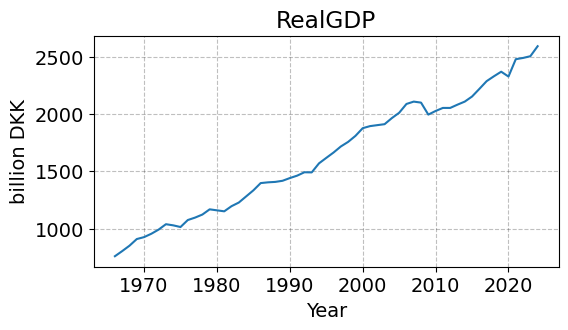

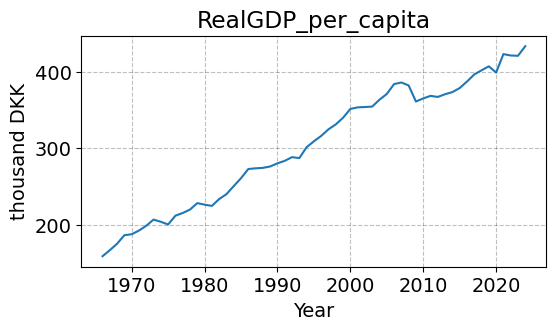

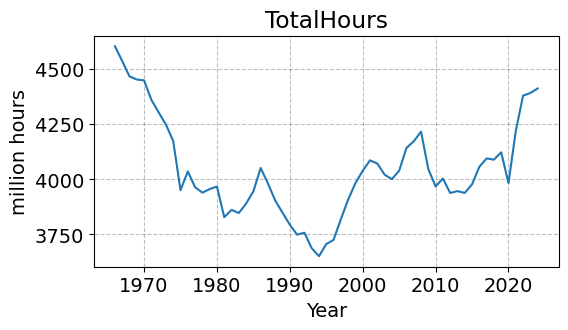

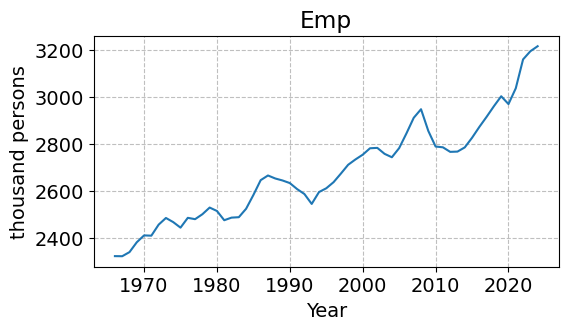

In [16]:
for col in df.columns:
    
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)
    ax.plot(df.index, df[col])
    ax.set_title(col)
    ax.set_xlabel('Year')
    ax.set_ylabel(units[col] if col in units else '')

Add more variables:

In [17]:
df['Pop'] = df['RealGDP']/df['RealGDP_per_capita']*1000
df['EmpRatio'] = df['Emp']/df['Pop']
df['Hours'] = df['TotalHours']/df['Emp']*1000
df['Productivity'] = df['RealGDP']/df['TotalHours']*1000

... and their units

In [18]:
units['Pop'] = 'thousand persons'
units['EmpRatio'] = ''
units['Hours'] = 'per employed'
units['Productivity'] = 'DKK per hour'

Plot overview figure:

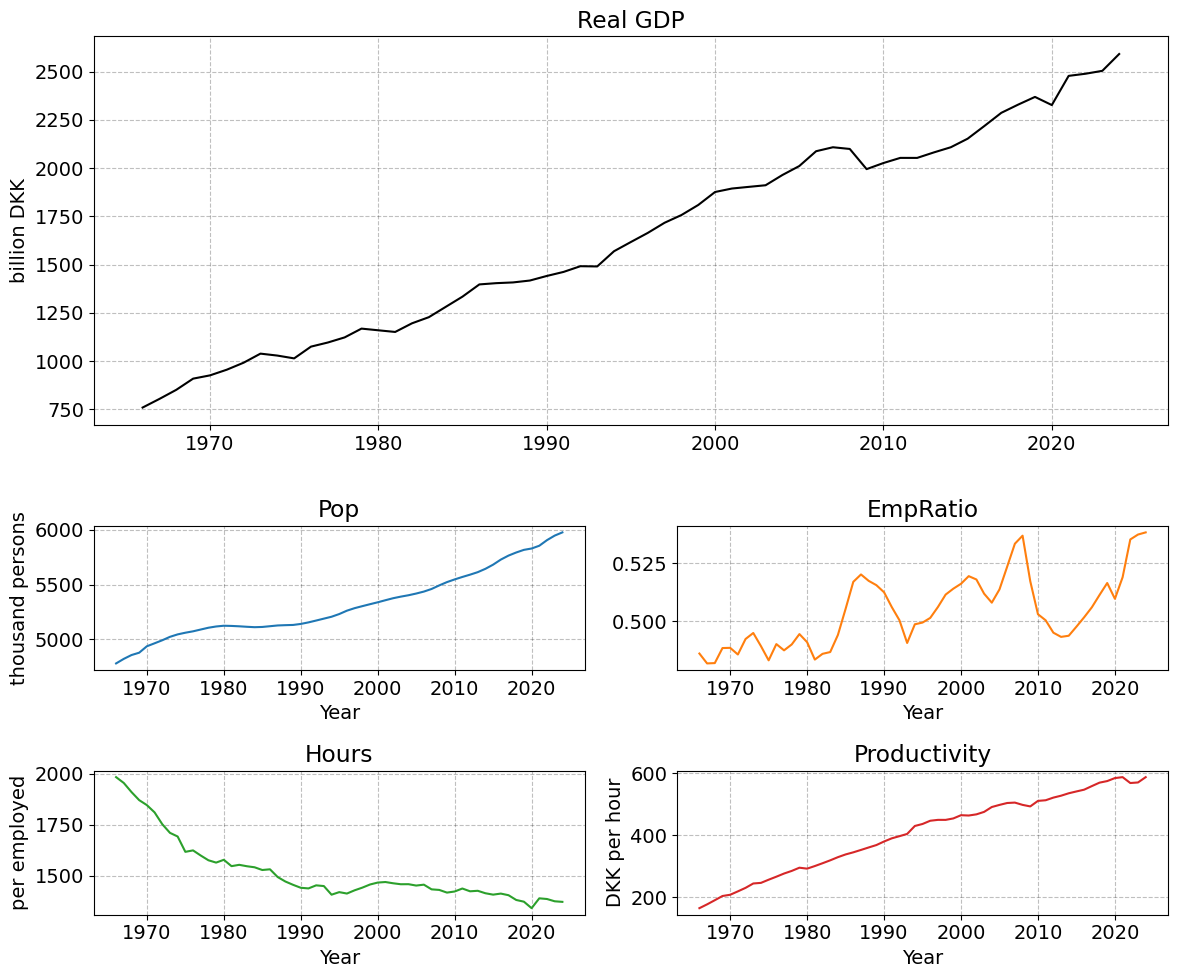

In [19]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(4,2,(1,4))
ax.plot(df.index, df['RealGDP'], color='black', label='Real GDP')
ax.set_title('Real GDP')
ax.set_ylabel(units['RealGDP'] if 'RealGDP' in units else '')

for i,varname in enumerate(['Pop','EmpRatio','Hours','Productivity']):
    ax = fig.add_subplot(4,2,5+i)
    ax.plot(df.index, df[varname], color=colors[i])
    ax.set_title(varname)
    ax.set_xlabel('Year')
    ax.set_ylabel(units[varname] if varname in units else '')

fig.tight_layout()

### 2.4. <a id='toc2_4_'></a>[Step 4: Analyze data](#toc0_)

In [20]:
def get_df_growth(df,varnames,dir='backward',first_decade=1960):

    # backward: 1959-1969, 1969-1979, ...
    # forward: 1960-1970, 1970-1980, ...
    
    # a. empty dataframe (rows = decade, columns = contribution from each variable)
    decades = np.arange(first_decade,2020+1,10)    
    index = [f'{decade}s' for decade in decades]
    df_growth = pd.DataFrame({varname:np.nan for varname in varnames}, index=index)

    for decade in decades:
        
        if dir == 'forward':
            I = (df.index >= decade) & (df.index <= decade+10)
            df_decade = df.loc[I]
            #df_decade = df.loc[decade:decade+10] # use .loc with index
        elif dir == 'backward':
            I = (df.index >= decade-1) & (df.index <= decade-1+10)
            df_decade = df.loc[I]
            df_decade = df.loc[decade-1:decade-1+10] # use .loc with index

        num_years = df_decade.index[-1]-df_decade.index[0]
    
        for varname in varnames:
            first = df_decade[varname].iloc[0]
            last = df_decade[varname].iloc[-1]
            df_growth.loc[f'{decade}s',varname] = ((last/first)**(1/num_years)-1)*100
            #df_growth.loc[f'{decade}s',varname] = (np.log(last)-np.log(first))/num_years*100
            
    return df_growth

In [21]:
varnames = ['RealGDP','Productivity','Hours','EmpRatio','Pop']
df_growth = get_df_growth(df,varnames,dir='backward')
df_growth.style.format('{:.2f}').set_caption('Average annual growth rates in percent')

,RealGDP,Productivity,Hours,EmpRatio,Pop
1960s,6.18,7.36,-1.93,0.16,0.68
1970s,2.54,3.76,-1.77,0.12,0.48
1980s,1.95,2.23,-0.72,0.42,0.03
1990s,2.47,2.12,0.01,-0.03,0.36
2000s,0.98,0.82,-0.28,0.06,0.37
2010s,1.73,1.54,-0.32,-0.01,0.52
2020s,1.81,0.44,-0.01,0.83,0.54


In [22]:
def stacked_bar_chart(df_growth,varnames,ylim=None):

    if ylim is None: ylim = [-2,8]
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)

    # running totals for positive and negative stacks
    pos_bottom = np.zeros(df_growth.shape[0])
    neg_bottom = np.zeros(df_growth.shape[0])

    for i,varname in enumerate(varnames[1:]):
        
        s = df_growth[varname].values

        # plot positive chunk stacked above pos_bottom
        pos = np.fmax(s,0)
        ax.bar(df_growth.index,pos,bottom=pos_bottom,color=colors[i],label=varname)
        pos_bottom = pos_bottom + pos

        # negative part
        neg = np.fmin(s,0)
        ax.bar(df_growth.index,neg,bottom=neg_bottom,color=colors[i])
        neg_bottom = neg_bottom + neg

    # GDP line
    ax.plot(df_growth.index, df_growth['RealGDP'], color='black',
            marker='o', linewidth=2, label='Real GDP')

    ax.set_ylim(ylim)
    ax.set_title('Growth Decomposition by Decade',pad=10)
    ax.set_ylabel('Annual growth rate')
    ax.legend(ncol=3)

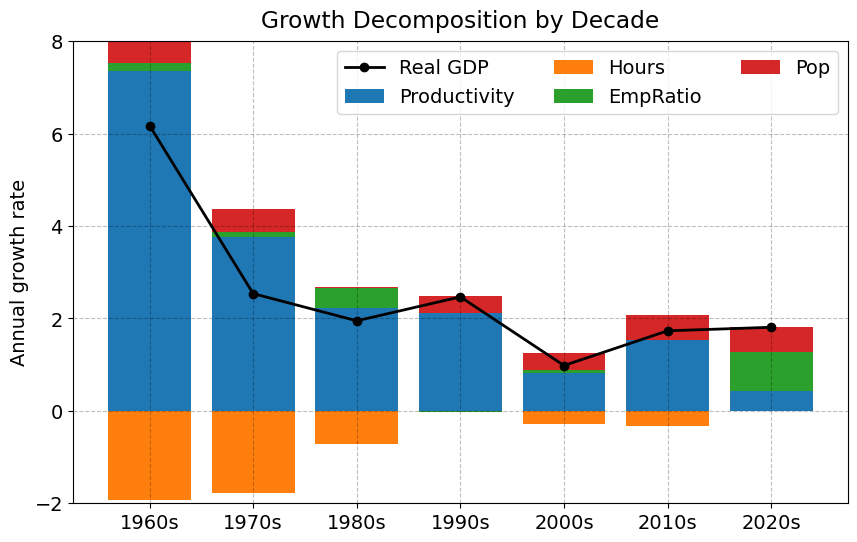

In [23]:
stacked_bar_chart(df_growth,varnames)

,RealGDP,Productivity,Hours,EmpRatio,Pop
1960s,5.08,5.98,-1.77,0.13,0.81
1970s,2.27,3.45,-1.56,0.05,0.37
1980s,2.19,2.65,-0.90,0.43,0.03
1990s,2.67,2.03,0.18,0.07,0.38
2000s,0.77,0.95,-0.30,-0.26,0.38
2010s,1.39,1.35,-0.59,0.13,0.50
2020s,2.73,0.13,0.57,1.38,0.63


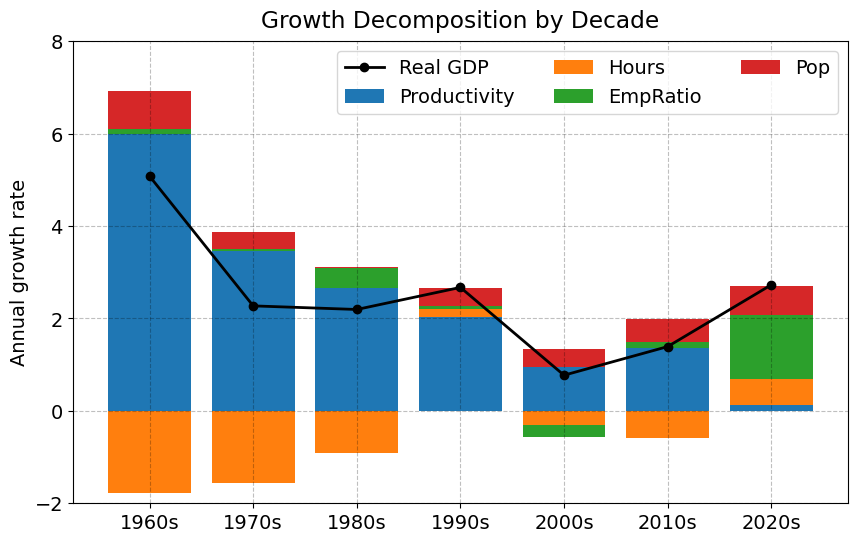

In [24]:
dir = 'forward'
df_growth_ = get_df_growth(df,varnames,dir=dir)
display(df_growth_.style.format('{:.2f}').set_caption('Average annual growth rates in percent'))
stacked_bar_chart(df_growth_,varnames)

## 3. <a id='toc3_'></a>[US data from FRED](#toc0_)

To access data from FRED you need to:

1. Create a FRED account [here](https://fredaccount.stlouisfed.org/login/secure/).
1. Request an API key [here](https://fredaccount.stlouisfed.org/apikeys).
1. Save in otherwise empty file `fredapi.txt` somewhere on your computer.

In [25]:
with open('c:/Users/gmf123/Dropbox/fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

**Step 1:** Search for the variables you need on https://fred.stlouisfed.org/.

In [26]:
series = {
     "GDPCA":"RealGDP",
     "CNP16OV":"Pop",
     "CE16OV":"Employment",
     "B4701C0A222NBEA":"TotalHours",
}

Check their meta data:

In [27]:
for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,GDPCA
title,Real Gross Domestic Product
frequency,Annual
units,Billions of Chained 2017 Dollars


series id,CNP16OV
title,Population Level
frequency,Monthly
units,Thousands of Persons


series id,CE16OV
title,Employment Level
frequency,Monthly
units,Thousands of Persons


series id,B4701C0A222NBEA
title,Hours worked by full-time and part-time employees
frequency,Annual
units,Millions of hours


**Step 2:** Download data from FRED.

In [28]:
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded GDPCA           from FRED and saved it as RealGDP        
Downloaded CNP16OV         from FRED and saved it as Pop            
Downloaded CE16OV          from FRED and saved it as Employment     
Downloaded B4701C0A222NBEA from FRED and saved it as TotalHours     


Resample to annual frequency:

In [29]:
for name,var in data.items():
    data[name] = var.resample("YS").mean()
    # YS = year start
    # YE = year end

Combine and drop any rows with missing observations:

In [30]:
df = pd.DataFrame(data)
#df = pd.concat(data.values(), axis=1).dropna() # does the same
df = df.dropna() # drop any rows with missing observations
df.head()

,RealGDP,Pop,Employment,TotalHours
1948-01-01,2274.627,103068.166667,58358.083333,99119.0
1949-01-01,2261.928,103994.333333,57682.583333,95610.0
1950-01-01,2458.532,104996.083333,58891.666667,100064.0
1951-01-01,2656.320,104622.083333,59966.750000,108525.0
1952-01-01,2764.803,105228.916667,60272.416667,110757.0


Change index to year and rename it to 'year':

In [31]:
df.index = df.index.year
df = df.rename_axis('year')
df.head()

,RealGDP,Pop,Employment,TotalHours
year,,,,
1948,2274.627,103068.166667,58358.083333,99119.0
1949,2261.928,103994.333333,57682.583333,95610.0
1950,2458.532,104996.083333,58891.666667,100064.0
1951,2656.320,104622.083333,59966.750000,108525.0
1952,2764.803,105228.916667,60272.416667,110757.0


Add variables:

In [32]:
df['EmpRatio'] = df['Employment'] / df['Pop']
df['Hours'] = df['TotalHours'] / df['Employment']*1000
df['Productivity'] = df['RealGDP'] / df['TotalHours']*1000
df['RealGDP'] = df['RealGDP']/1000
df['Pop'] = df['Pop']/1000
df.head()

,RealGDP,Pop,Employment,TotalHours,EmpRatio,Hours,Productivity
year,,,,,,,
1948,2.274627,103.068167,58358.083333,99119.0,0.566209,1698.462224,22.948446
1949,2.261928,103.994333,57682.583333,95610.0,0.554670,1657.519384,23.657860
1950,2.458532,104.996083,58891.666667,100064.0,0.560894,1699.119853,24.569595
1951,2.656320,104.622083,59966.750000,108525.0,0.573175,1809.752905,24.476572
1952,2.764803,105.228917,60272.416667,110757.0,0.572774,1837.606755,24.962783


**Step 3:** Verify data.

In [33]:
units_us = {
    'RealGDP': 'trillions of $',
    'Pop': 'millions of persons',
    'EmpRatio': '',
    'Hours': 'per employed',
    'Productivity': '$ per hour',
}

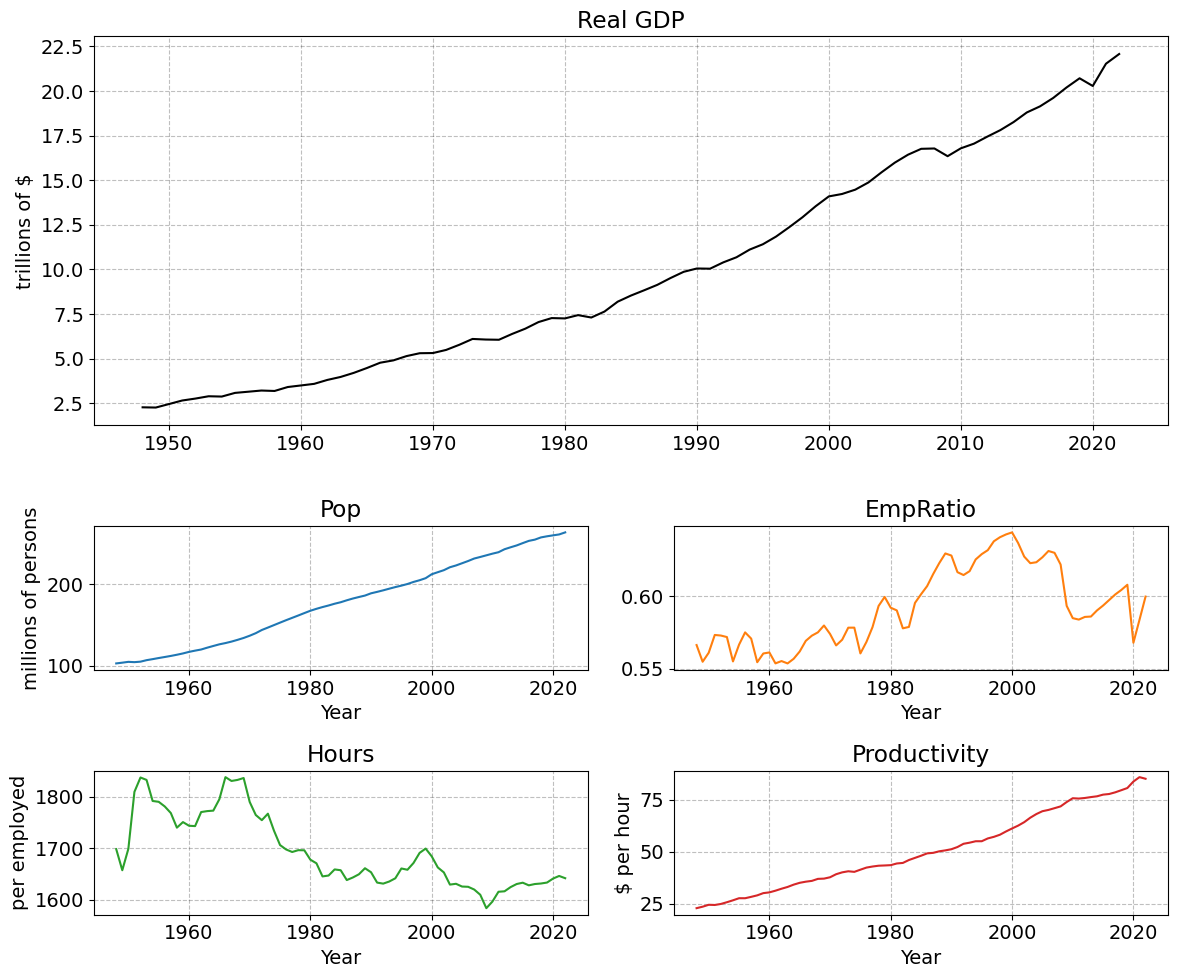

In [34]:
# plot the newly created variables
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(4,2,(1,4))
ax.plot(df.index, df['RealGDP'], color='black', label='Real GDP')
ax.set_title('Real GDP')
ax.set_ylabel('GDP')
ax.set_ylabel(units_us['RealGDP'] if 'RealGDP' in units_us else '')

for i,varname in enumerate(['Pop','EmpRatio','Hours','Productivity']):
    ax = fig.add_subplot(4,2,5+i)
    ax.plot(df.index, df[varname], color=colors[i])
    ax.set_title(varname)
    ax.set_xlabel('Year')
    ax.set_ylabel(units_us[varname] if varname in units_us else '')

fig.tight_layout()

**Step 4:** Analyze data.

,RealGDP,Productivity,Hours,EmpRatio,Pop
1940s,3.96,3.47,0.02,-0.47,0.93
1950s,3.60,2.19,0.26,0.00,1.11
1960s,4.27,2.15,0.26,0.23,1.58
1970s,3.16,1.44,-0.64,0.31,2.04
1980s,3.31,1.63,-0.15,0.59,1.21
1990s,3.44,1.79,0.19,0.25,1.17
2000s,1.76,2.15,-0.53,-0.96,1.13
2010s,1.91,1.01,0.28,-0.29,0.91
2020s,4.32,0.79,0.02,2.77,0.70


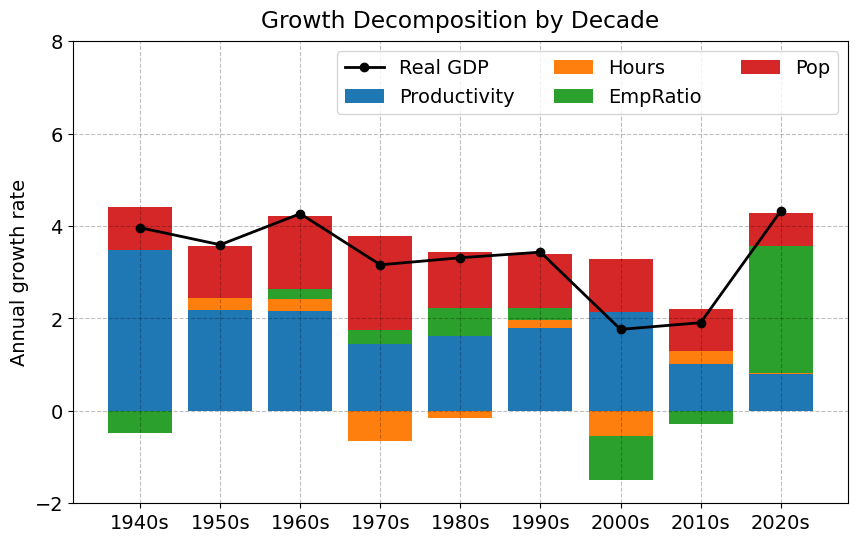

In [35]:
df_growth_ = get_df_growth(df,varnames,dir='forward',first_decade=1940)
display(df_growth_.style.format('{:.2f}').set_caption('Average annual growth rates in percent'))
stacked_bar_chart(df_growth_,varnames)

## 4. <a id='toc4_'></a>[Summary](#toc0_)

The main takeways are:

- Downloading data from API
- Clean data (`.rename`, `.drop`, `.astype` etc.) 
- Structure data (join on index and `.pivot_table`)
- Analyzing and plotting data

Any questions on getting and analyzing data from an API?

**Socrative room:** PROGECON